# K-means Clustering and LSTM Neural Network for Economic Regime Classifier and Stock Market Forecast
### Ian Alexei Zelaya 


We are in the era of artificial intelligence and digital technology. 
Machine learning, a form of artificial intelligence, is forcing evolution in many different industries such as health care, automobile and retail. In finance, machine learning has supported a relatively new form of investment strategy, known as quantitative finance. The objective of quantitative strategies is to find patterns, cycles and trends through mathematical models and invest based on what the models suggest. Despite the fact that mathematical models have been available in previous decades, quantitative models are gaining massive popularity in the investment community as machine learning models have brought new opportunities to construct more precise and complex algorithms. 

In this project, I implemented an LSTM neural network based on macroeconomic features, technical analysis and a K-Means classifier of the stages in the U.S. business cycle. The objective of the K-Means classifier was to help the LSTM model make better predictions by considering the current and previous stages of the business cycle. Before implementing the LSTM model, it was necessary to construct a K-Means classifier that successfully predicts the business cycle so that its classification could be used as a leading indicator of how the economy would perform in the near future. For this reason, the project is divided in two parts. Part I is focused on the K-Means classifier and Part II on the LSTM model. 

## Table of Contents

* [Part I: K-means Classifier](#PartI)
    * [Import and Data Preprocessing](#PartI-I)
    * [Data Exploration](#PartI-II)
    * [Data Clustering with K-Means](#PartI-III)
  
* [Part II: LSTM Neural Network](#PartII)
    * [Preparing Dataset for Neural Network](#PartII-I)
    * [LSTM Neural Network Modeling](#PartII-II)
    * [Evaluation of LSTM Model](#PartII-III)
* [Conclusions and Further Improvements](#Ending)

## Part I: K-Means for Business Cycle Classification <a class="anchor" id="PartI"></a>

The data used in this proyect is extracted from the OECD (Organization for Economic Co-operation and Development) and the Federal Reserve Economic Data (FRED). In part I of this project, the format of the data is monthly and ranges from 1956 to 2020-05. 

To begin, data is extracted from the data folder and then preprocessed in an automated manner. The preprocessing includes optional moving averages to capture long term trends in different features and "differencing" to convert non-stationary series into stationary (necessary to train machine learning models). Similar to a moving average, I decided to use multi-period changes to help the model understand how much it has changed since a certain period of time     (Ex. substract the current value with a value from three periods ago). A Pandas DataFrame with a date index is created by concatenating all features as columns. Feature scaling was also applied to all features in order to normalize the range of values and adjust to the distance measurements used by the K-Means to create the clusters. The following formula details the standard scaler transform :

$$\mathbf{\text{Standard Scaler}}$$
\begin{equation*}
Z = \frac{X - \mu}{\sigma} \\
\end{equation*}

\begin{equation*}
\mu = Mean \\
\end{equation*}

\begin{equation*}
\sigma = Standard Deviation \\
\end{equation*}

If we want the algorithm to be useful with future data, one critical aspect to consider before using the data is the publishing date of the data. Most macroeconomic data are published with a lag (Ex. data from January gets published around February 15th) and as a result, the data of a particular month was not available in that moment. Some research papers and data science projects do not consider this lag and the consequence is an unrealistic model. To adjust to this lag, data is shifted to use data from two months ago. Once used in a real-world scenario, the algorithms performance could improve as it will update earlier than two months lag.

### Import and Data Preprocessing <a class="anchor" id="PartI-I"></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
from scipy.stats import mode
import pickle
from statsmodels.graphics.tsaplots import plot_acf 

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 5000)

In [15]:
dirct = r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset'

class data_preprocessing: 
    
    @staticmethod
    def data_input(filename, featurename, existing_dataset=False, change=False, moving_average=False, diff=False, 
                   multiple=False, delimiter=',', start_date=False, end_date=False):
        
        """Transformation of a dataset with first column as date. Time series adjusted to begin from 1956, with 3-
        12- and 50-month changes as new columns. Input may be single or multiple variable datasets
        
        Params:
        change and moving_average accepts values as lists. Example: change([12]) for the change of 12 periods"""

        if multiple is True:
            data = pd.read_csv(r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset\{}'.format(filename), 
                               delimiter=delimiter, index_col=0)
            data.columns.values[0] = featurename
            differencing = data.pct_change() if diff is True else None
            
            # Replace original data with differencing   
            if differencing is not None:
                data.iloc[:, :differencing.shape[1]] = differencing
            
            for column in data: 
                # Adding the change in a period of months as new columns of the dataset
                if change is not False:
                    for m in change:
                        data['{}-M {}'.format(m, column)] = data[column] - data[column].shift(m) 
                    
                if moving_average is not False:
                    for ma in moving_average:
                        data['{}-MA {}'.format(ma, column)] = data[column].rolling(ma).mean()
            
            
            # Slicing dataset with custom start and end dates
            if start_date is not False:
                data = data.loc['{}'.format(start_date):'{}'.format(end_date)]
                
            else:
                data = data.loc['1956':'2020-06-01']
                
            # Adding new columns into an existing dataset if true
            if existing_dataset is not False:
                data = pd.concat([existing_dataset, data], axis=1, sort=True)
                return data
            
            else:
                return data

        else:
            data = pd.read_csv(r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset\{}'.format(filename), 
                               delimiter=delimiter, index_col=0)
            data.columns.values[0] = featurename
            differencing = data.pct_change() if diff is True else None

            # Replace original data with differencing  
            if differencing is not None:
                data[featurename] = differencing
                
            # Adding the change in a period of months as new columns of the dataset
            if change is not False:
                for m in change:
                    data['{}-M {}'.format(m, featurename)] = data.iloc[:,0] - data.iloc[:,0].shift(m)
                    
            if moving_average is not False:
                for ma in moving_average:
                    data['{}-MA {}'.format(ma, featurename)] = data.iloc[:,0].rolling(ma).mean()
                
            # Slicing dataset with custom start and end dates
            if start_date is not False:
                data = data.loc['{}'.format(start_date):'{}'.format(end_date)]
                
            else:
                data = data.loc['1956':'2020-06-01']
                
            # Adding new columns into an existing dataset if true
            if existing_dataset is not False:
                data = pd.concat([existing_dataset, data], axis=1, sort=True)
                return data
            
            else:
                return data

    @staticmethod
    def feature_scaling(data, single_array=False, single=False):
        """Feature scaling using Standard Scaler"""

        if single is not False:
            standard = StandardScaler()
            scaled = standard.fit(single_array)
            scaled = scaled.transform(single_array)
            scaled = np.squeeze(scaled)
            scaled = pd.Series(scaled)
            scaled.name = data.name
            scaled.index = data.index

        else:
            standard = StandardScaler()
            scaled = standard.fit(data)
            scaled = scaled.transform(data)
            scaled = pd.DataFrame(scaled)
            scaled.columns = data.columns
            scaled.index = data.index
            
        return scaled

    
data1 = data_preprocessing()
OECD = data1.data_input('OECD_CLI.csv', 'OECD CLI', delimiter=';', change=[3])

data2 = data_preprocessing()
unemploy_rate = data2.data_input('UNRATE.csv', 'Unemploy rate', OECD, change=[3, 12])


X = data_preprocessing()
X_scaled = X.feature_scaling(unemploy_rate)
X_scaled = X_scaled.drop(columns=['Unemploy rate'])


## Shift values to adjust to the time-lag that takes for the OECD and Employment Situation to publish data from previous  
## months. Normally, the OECD and civilian unemployment rates publishes the data of a month mid the next month
## (Ex. Data from January gets published around February 15). Due to this lag, data of a month was not available in the same 
## month. For this indicator to be of value in a real-world scenario, a lag of two months has been made. Once used in a real-world
## scenario, the indicator can be even more precise as it will indicate the stage of month the same day the data has been published.
X_scaled = X_scaled.shift(2).dropna()
display(X_scaled.head())

,OECD CLI,3-M OECD CLI,3-M Unemploy rate,12-M Unemploy rate
1956-03-01,1.207512,-0.780813,-0.498738,-0.760412
1956-04-01,0.979529,-1.081266,-0.498738,-0.677389
1956-05-01,0.756809,-1.256445,-0.039051,-0.345300
1956-06-01,0.549296,-1.277710,-0.039051,-0.594367
1956-07-01,0.369678,-1.180645,0.573866,-0.013211


### Data Exploration <a class="anchor" id="PartI-II"></a>

Executing a correlation matrix is always a good idea to better understand the relationship between features. As expected, the correlation between features and their respective multi-period changes are higher than the correlation between different features. A correlation higher than 80% would indicate that some features do not provide significant information to use for the model and thus should be eliminated. In this case, correlations are within an acceptable range. After the correlation matrix, I plotted the features' time series and here we can see how the feature scaling transformed values to range around the zero value. The benefit of using a multi-period change seems to be clear as they provide less noisy time series. This is the main reason why I decided to avoid the monthly unemployment rate and replace it with its multi-period changes. Both, the OECD CLI and unemployment rate, have an clear oscilation with periods of expansion and contraction in the whole time series. An important insight from these time series is the unprecedented values of the last months due to COVID-19 crisis. 

Lastly, we evaluate the autocorrelation between features and their lagging values to identify any correlation that may help us to create more information for the model. 

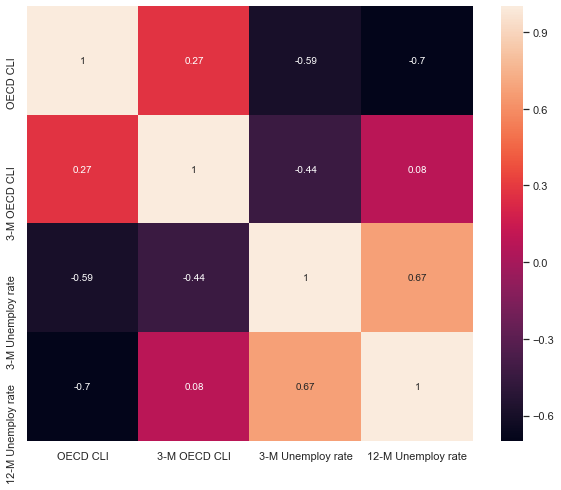

OECD CLI:


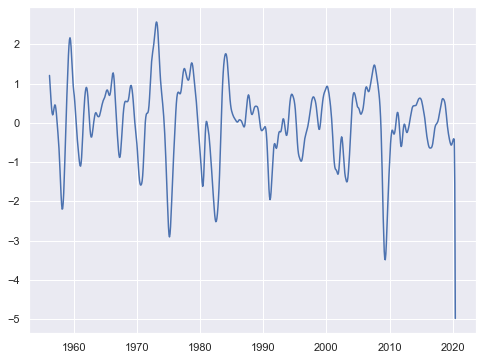

3-M OECD CLI:


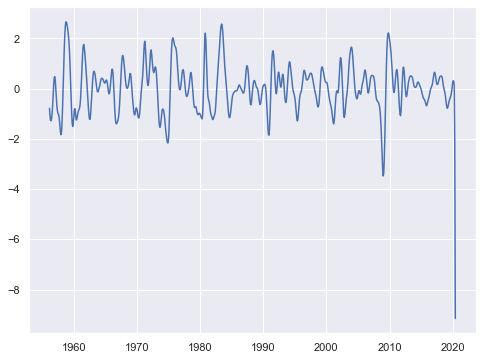

3-M Unemploy rate:


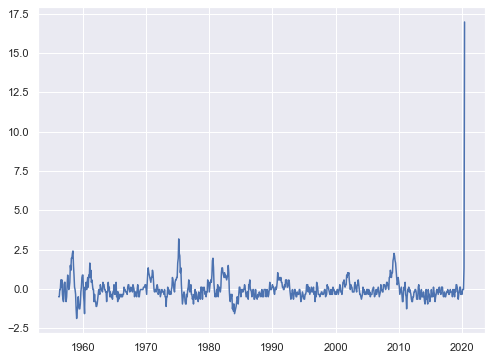

12-M Unemploy rate:


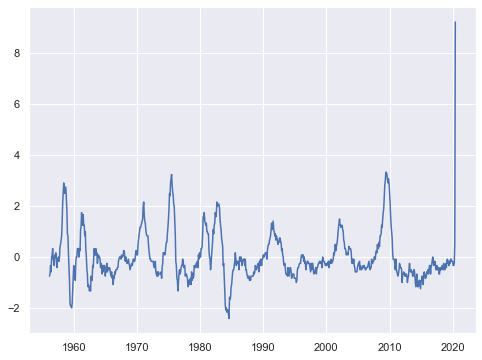

OECD CLI autocorrelation:


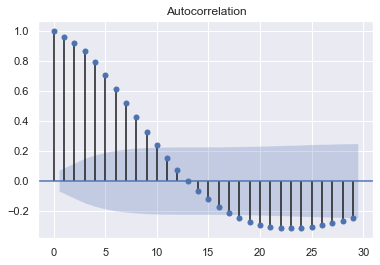

3-M OECD CLI autocorrelation:


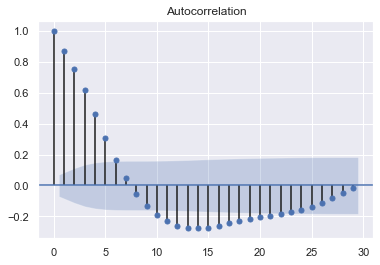

3-M Unemploy rate autocorrelation:


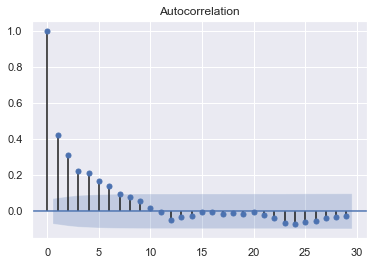

12-M Unemploy rate autocorrelation:


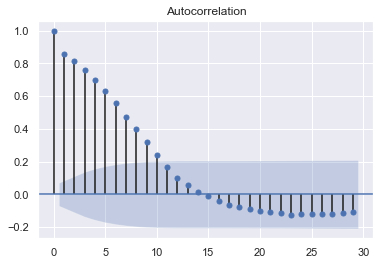

In [16]:
## Create a copy dataframe for plotting 
X_plot = X_scaled.copy()

## Plot correlations between feature variables
correlations = X_plot.corr().round(2)
plt.figure(figsize=(10, 8))
pt = sns.heatmap(correlations, annot=True)
pt.set_xlim(0, X_plot.shape[1])
pt.set_ylim(X_plot.shape[1], 0)
plt.show()

## Plot variables through time 
X_plot['Date'] = X_plot.index
X_plot['Date'] = X_plot['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

for i in X_plot.columns[:-1]:
    print(i + ':')
    plt.figure(figsize=(8,6))
    plt.plot(X_plot['Date'], X_plot[i])
    plt.show()

for i in X_plot.columns[:-1]:
    print(i + ' autocorrelation:')
    plot_acf(X_plot[i])
    plt.show()

### Data Clustering with K-Means <a class="anchor" id="PartI-III"></a>

According to Wikipedia, K-means aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. At first, the K-means algorithm tries random centroids, $c^{(i)}$. Given a dataset  ${x^{(1)}, ... , x^{(m)}}$, each data point $x^{(i)}$ is assigned to the nearest centroid by a distance measure. Then, each centroid $c^{(i)}$ is recalculated by finding the mean of the data points assigned to it previously. This process continues until it hits with a threshold either of maximum iterations or minimum change of the centroids. 

The scikit-learn library provides an implementation of the K-means algorithm and we will use it for this project. As function inputs, I determined to use five clusters in order to identify all stages of the business cycle (slowdown, recession, recovery and expansion) plus the unprecedented scenario experienced in the first months of 2020.

In [339]:
## Feed the K-means algorithm with 5 clusters as a parameter to include the current severe economic downturn.
## This is important as severe economic downturns are historically cyclical (last time in 1932 for the U.S.)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_scaled)
print(kmeans.labels_)
X_labeled = X_scaled.copy()
X_labeled['Labels'] = kmeans.labels_
print(X_labeled[X_labeled['Labels']==4])


[0 0 4 4 4 4 4 4 0 0 0 0 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 0
 0 0 0 0 0 0 0 0 4 4 0 0 0 4 4 4 4 4 4 4 4 4 1 1 3 3 3 3 3 3 3 3 0 0 0 0 0
 0 4 4 4 4 4 4 4 4 0 4 4 0 0 4 0 4 0 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3
 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4
 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 3 3
 3 3 3 3 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4
 4 4 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0
 0 0 0 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 0 4 4 4 4 4 

In [4]:
# Save pandas dataframe as a .csv file 
#X_labeled.to_csv('X_labeled.csv')
X_labeled = pd.read_csv('X_labeled.csv', index_col=0)

# Save the weights of the kmeans model as .sav file
#pickle.dump(kmeans, open('Kmeans_weights.sav', 'wb'))

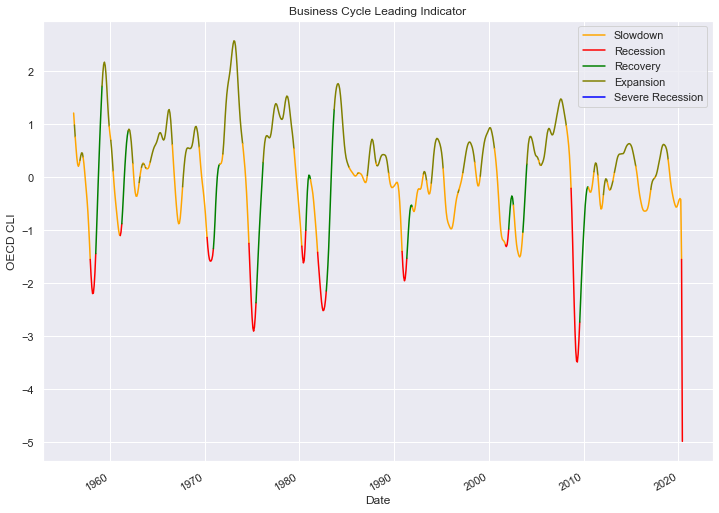

In [5]:
## Convert labels to colors
label2color = {
    4: 'orange',
    1: 'red',
    3: 'green',
    0: 'olive',
    2: 'blue',
}

X_plot = X_labeled.copy()
X_plot['color'] = X_plot['Labels'].apply(lambda label: label2color[label])
X_plot.index = pd.to_datetime(X_plot.index)

## Create plot
fig, ax = plt.subplots()

def gen_repeating(s):
    """Generator: groups repeated elements in an iterable
    E.g.
        'abbccc' -> [('a', 0, 0), ('b', 1, 2), ('c', 3, 5)
        
        Returns: the element, the starting and the ending index of the repeated element sequence
    """
    i = 0
    while i < len(s):
        j = i
        while j < len(s) and s[j] == s[i]:
            j += 1
        yield (s[i], i, j-1)
        i = j

## Plot OECD CLI with aggregated sliced dates according to their label of stage in the business cycle and color 
for color, start, end in gen_repeating(X_plot['color']):
    if start > 0: # make sure lines connect
        start -= 0
    idx = X_plot.index[start:end+2]
    X_plot.loc[idx, 'OECD CLI'].plot(ax=ax, color=color, label='', figsize=(12,9))

    
handles, labels = ax.get_legend_handles_labels()
    
## Create custom artists
o_line = plt.Line2D((0,1),(0,0), color='orange')
r_line = plt.Line2D((0,1),(0,0), color='red')
g_line = plt.Line2D((0,1),(0,0), color='green')
y_line = plt.Line2D((0,1),(0,0), color='olive')
b_line = plt.Line2D((0,1),(0,0), color='blue')

## Create legend from custom artist/label lists
ax.legend(
    handles + [o_line, r_line, g_line, y_line, b_line],
    labels + [
        'Slowdown',
        'Recession',
        'Recovery',
        'Expansion',
        'Severe Recession'
    ],
    loc='best',
)

## Display plot
plt.title('Business Cycle Leading Indicator')
plt.ylabel('OECD CLI')
plt.xlabel('Date')
plt.show()

As you can see, K-means has classified the stages of the business cycle successfully and serves as a leading indicator. The slowdown stage may have a particular value as it signals when stock prices usually decline as investors discount the future possibility of a recession and lower corporate profits.

## Part II: LSTM Neural Network <a class="anchor" id="PartII"></a>

In part II of the project, I attempted to predict the DJI (Dow Jones Industrial Average) weekly data through an LSTM Neural Network. Before using the LSTM neural network, I tried applying the standard neural network and obtained a poor performance. After performing a research about neural networks models to forecast time series, the LSTM neural network was the most promising. 


As explained before, the labels obtained from the K-means classifier were transformed into a feature for the neural network. Additionally, I created a feature from the labels with the function "labels_time_since" to count the periods since the last change of stage. The intention for the "time since" feature was to help the model understand how long has the current stage been dominant. Macroeconomic and technical features were also added to enrich the dataset. The following list specifies the variables used as features for the LSTM model:

- OECD CLI
- Unemployment rate
- Labels from the K-Means Classifier
- Number of periods since the current stage began
- U.S. Initial Jobless Claims: weekly number of fillings for unemployment benefits
- VXO Index: an indicator for level of volatility in financial markets (predecessor of the popular VIX index)
- OHLC: open, high, low and close prices from previous periods of the DJI



After using the monthly data used in part I in an iteratively manner for part II, I found out more data points would be necessary to capture patterns with the LSTM neural network. Therefore, I decided to convert the monthly data into weekly data through the function "convert_to_weekly". This function also converts features which were extracted in a daily format. 

Once the dataset is prepared, it is time to implement the LSTM Model. 

### Preparing Dataset for Neural Network <a class="anchor" id="PartII-I"></a>

In [90]:
# Import libraries for the neural network
import keras
print('Keras Version: ' + keras.__version__)
import tensorflow as tf 
print('Tensorflow Version: ' + tf.__version__)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 5000)

scaling_labels = X_labeled['Labels'].copy()
array_labels = np.array(scaling_labels).reshape(-1, 1)
data3 = data_preprocessing()
scaling_labels = data3.feature_scaling(scaling_labels, array_labels, single=True)


def macro_data(filename, new_file, save=True):
    directory = r'C:\Users\adminit\Data Science Projects\ML BC Project\Dataset\us'
    
    for i in os.listdir(directory):
        
        if i == filename:
            data = pd.read_csv(directory + '/' + filename)
            data_sliced = data[['<DATE>', '<OPEN>']]
            data_sliced = data_sliced.rename(columns={'<DATE>': 'Date', '<OPEN>': '{}'.format(new_file[:-4])})
            data_sliced['Date'] = pd.to_datetime(data_sliced['Date'], format='%Y%m%d')
            if save is True:
                data_sliced.to_csv(directory[:-2] + new_file, index=False)
                
            return data_sliced
        
        
def labels_time_since(data):
    counter = []
    time_since = []
    
    for i, columnValue in data.iteritems():

        if len(counter) < 1:
            counter.append(columnValue)
            time_since.append(len(counter))
            
        elif columnValue == counter[-1]:
            counter.append(columnValue)
            time_since.append(len(counter))
        
        else:
            counter.clear()
            counter.append(columnValue)
            time_since.append(len(counter))

    return time_since


def convert_to_weekly(data, monthly=False, daily=False,  offset=False, ffill='first'):
    data.index = pd.to_datetime(data.index)
    
    if monthly is not False:
        data = data.resample('W').ffill()
        
    if daily is not False:
        if offset is not False:
            offset = pd.offsets.timedelta(offset)
            data = data.resample('W', loffset = offset).apply('{}'.format(ffill))

        else:
            data = data.resample('W').apply('{}'.format(ffill))
    
    return data
    
    
time_since = pd.Series(labels_time_since(scaling_labels))
array_since = np.array(time_since).reshape(-1, 1)
data_number = data_preprocessing()
time_since = data_number.feature_scaling(time_since, array_since, single=True)


## Import new features for the X dataset of the neural network
data4 = data_preprocessing()
DJI = data4.data_input('dji_w.csv', 'Open', multiple=True, delimiter=',', moving_average=[3, 12])
DJI = DJI.dropna()
DJI = DJI[['High', 'Low', 'Close', '12-MA Close', 'Open', 'Volume']]
DJI['Volume'] = (DJI['Volume'].rolling(3).sum())/3
DJI.index = pd.to_datetime(DJI.index)
DJI = DJI.loc['1986':'2020-06']
DJI = DJI.tshift(periods = 1, freq = 'D') #Adjust to begin in monday


# Variables extracted from the macro_data file

# Initial Claims
init_claims = macro_data('injcus.m.txt', 'InitClaims.csv')

data5 = data_preprocessing()
init_claims = data5.data_input('InitClaims.csv', 'InitClaims', start_date='1986', end_date='2020-06')
init_claims.index = pd.to_datetime(init_claims.index)
init_claims = init_claims.resample('D').ffill()
init_claims = convert_to_weekly(init_claims, offset=1, ffill='last', daily=True)
init_claims = init_claims.join(DJI)

# The rest of the variables downloaded individually

# VXO Index 
data6 = data_preprocessing()
vxo = data6.data_input('vxo.csv', 'VXO', delimiter=';', start_date='1986', end_date='2020-06')
vxo = convert_to_weekly(vxo, offset=1, ffill='last', daily=True)
vxo = vxo.join(init_claims)

data7 = data_preprocessing()
X_NN_scaled = data7.feature_scaling(vxo)


# # In the X dataset, add columns with values from previous months (3 and 12 month lag) of the column 'Labels'  
# # and drop rows with nan values due to the new columns. The objective is to help the neural network to learn 
# # if a label in month 't' is new or a continuation of a sequence of the label.
X_NN = X_labeled.copy()
X_NN['Labels'] = scaling_labels
X_NN['Time Since'] = time_since.values
X_NN['3-M Label'] = X_NN['Labels'].rolling(3).apply(lambda x: mode(x)[0] )
X_NN = convert_to_weekly(X_NN, monthly=True)
X_NN = X_NN.tshift(periods = -6, freq = 'D')
X_NN = pd.concat([X_NN, X_NN_scaled], axis=1, sort=True)
X_NN = X_NN.drop(columns=['12-M Unemploy rate'])
X_NN = X_NN.dropna()
X_NN = X_NN[:-1]
display(X_NN.head())


# Windows for the LSTM Neural Network input
history_points = 5
X_NN = np.array(X_NN)
X_NN_1 = np.array([X_NN[i: i + history_points].copy() for i in range(len(X_NN) - history_points)])     
X_test2 = X_NN_1[-6:]
X_NN_1 = X_NN_1[:-6]


# Converting positive monthly returns into "1" and negative monthly return into "0" for classifier NN
def pos_neg_converter(Y):
    row_counter = []
    for i in Y.columns:
        row_counter.clear()
        for j in Y[i]:
            row_counter.append(j)
            if j > 0:
                Y[i][len(row_counter)-1] = 1
            else:
                Y[i][len(row_counter)-1] = 0
    return Y 


Y =  np.array([X_NN[:,10][i + history_points].copy() for i in range(len(X_NN) - history_points)])
Y = np.expand_dims(Y, -1)

Y_test2 = Y[-6:]
Y = Y[:-6]

Keras Version: 2.3.1
Tensorflow Version: 2.3.0


,OECD CLI,3-M OECD CLI,3-M Unemploy rate,Labels,Time Since,3-M Label,VXO,InitClaims,High,Low,Close,12-MA Close,Open,Volume
1986-01-06,0.028677,0.021600,-0.19228,1.171901,0.278560,1.171901,-0.148489,-0.021960,-1.323803,-1.313307,-1.317614,-1.328104,-1.318320,-1.126549
1986-01-13,0.028677,0.021600,-0.19228,1.171901,0.278560,1.171901,0.028798,0.089812,-1.321512,-1.317619,-1.323016,-1.326269,-1.317380,-1.139829
1986-01-20,0.028677,0.021600,-0.19228,1.171901,0.278560,1.171901,-0.104436,-0.015573,-1.325346,-1.316591,-1.319506,-1.323984,-1.322790,-1.123602
1986-01-27,0.051166,0.098413,-0.19228,1.171901,0.422213,1.171901,-0.318254,-0.079442,-1.327607,-1.318217,-1.320534,-1.322214,-1.319380,-1.113998
1986-02-03,0.051166,0.098413,-0.19228,1.171901,0.422213,1.171901,-0.104436,-0.015573,-1.320793,-1.313200,-1.314316,-1.320101,-1.320305,-1.116056


In [106]:
# Dividing the dataset into train and test set
train_size = 0.9
n = int(X_NN.shape[0] * train_size)

X_train = X_NN_1[:n]
X_test = X_NN_1[n:]

Y_train = Y[:n]
Y_test = Y[n:]


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(1615, 5, 14) (1615, 1)
(169, 5, 14) (169, 1)


### LSTM Neural Network Modeling <a class="anchor" id="PartII-II"></a>

The LSTM neural network works in a sequential manner, meaning that for every data point, the model requires a fixed group of previous periods as input.   

Epoch 1/75
54/54 [==============================] - 1s 21ms/step - loss: 0.4947 - val_loss: 3.8274
Epoch 2/75
54/54 [==============================] - 0s 6ms/step - loss: 0.3496 - val_loss: 3.0831
Epoch 3/75
54/54 [==============================] - 0s 5ms/step - loss: 0.1848 - val_loss: 2.3959
Epoch 4/75
54/54 [==============================] - 0s 6ms/step - loss: 0.0830 - val_loss: 1.6988
Epoch 5/75
54/54 [==============================] - 0s 5ms/step - loss: 0.0450 - val_loss: 1.2497
Epoch 6/75
54/54 [==============================] - 0s 5ms/step - loss: 0.0339 - val_loss: 1.0718
Epoch 7/75
54/54 [==============================] - 0s 5ms/step - loss: 0.0322 - val_loss: 1.0234
Epoch 8/75
54/54 [==============================] - 0s 7ms/step - loss: 0.0285 - val_loss: 0.9900
Epoch 9/75
54/54 [==============================] - 0s 8ms/step - loss: 0.0262 - val_loss: 0.9725
Epoch 10/75
54/54 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.9578
Epoch 11/75
54/54 

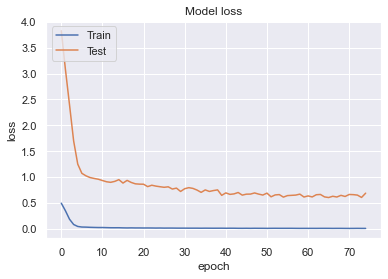

In [109]:
## Construction of the neural network structure and parameters
input_dim = X_NN.shape[1]
output_dim = 1
batch_size = 30

def defining_network():
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_NN_1.shape[1], X_NN_1.shape[2])))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(output_dim, activation='linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='MSE', optimizer=opt)
    history = model.fit(X_train, Y_train, epochs=75, batch_size=batch_size, 
                        shuffle=True, validation_data=(X_test, Y_test))
    
    return history, model
    
    
history, model = defining_network()

# Save the model
model.save('lstm_model.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### LSTM Model Evaluation <a class="anchor" id="PartII-III"></a>

The implementation of machine learning to time series is quite different than other types of data such as images, music and videos. For example, time series data tends to be limited, which forces the machine learning engineer to use other methods in order to obtain high accuracy in the test set. 


In particular, financial time series contain a high noise to signal ratio and as a result lacks of clear patterns when converting to a stationary form. This is a problem as many machine learning algorithms require stationary data to model reliable and consistent predictions. Many researchers and machine learning engineers have looked for ways to solve this issue. [Marcos Lopez de Prado](https://www.linkedin.com/in/lopezdeprado/) suggested in his book, "Advances in Machine Learning for Finance",  a method called fractional differencing to make a semi-stationary time series. Others, such as [Skander Hannachi](https://www.linkedin.com/in/skander-hannachi-3835618/), AI/machine learning specialist at Google Cloud, argues that time series models can be trained with non-stationary data by retraining the model every time we have a new data point [[here]](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387). This proyect followed the recommendation made by Dr. Hannachi.  




Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_97 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_40 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_98 (Dense)             (None, 12)                612       
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 13        
Total params: 16,175
Trainable params: 16,175
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
51/51 [==============================] - 0s 6ms/step - loss: 0.0071
Epoch 2/15
51/51 [=============

51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 10/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 11/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 12/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 13/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 14/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 15/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Data point 12:
Epoch 1/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 2/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 3/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 4/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 5/15
51/51 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 6/15
51/51 [========================

52/52 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 2/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 3/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 4/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 5/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 6/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 8/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 9/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 10/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 11/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 12/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 13/15
52/52 [==============================] - 0s 4ms/

52/52 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 8/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0015 ETA: 0s - loss: 0.00
Epoch 9/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 10/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 11/15
52/52 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 12/15
52/52 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 13/15
52/52 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 14/15
52/52 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 15/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0013
Data point 39:
Epoch 1/15
52/52 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 2/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 3/15
52/52 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 4/15
52/52 [===

53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 14/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 15/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0012
Data point 52:
Epoch 1/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 2/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 4/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 5/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 7/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 9/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/15
53/53 [===========================

53/53 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 5/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 7/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 10/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 11/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 12/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 13/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0013- ETA: 0s - loss: 0.0016
Epoch 14/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 15/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Data point 66:
Epoch 1/15
53/53 [

53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 12/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 13/15
53/53 [==============================] - 0s 4ms/step - loss: 9.7552e-04
Epoch 14/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 15/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Data point 79:
Epoch 1/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 5/15
53/53 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/15
53/53 [==============================] - 0s 5ms/step - loss: 9.8406e-04
Epoch 7/15
53/53 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 8/15
53/53 [==================

54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3/15
54/54 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 5/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 6/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 7/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 8/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 12/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 13/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 14/15
54/54 [==============================] - 0s 4ms

54/54 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 14/15
54/54 [==============================] - 0s 4ms/step - loss: 9.8955e-04
Epoch 15/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Data point 99:
Epoch 1/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2/15
54/54 [==============================] - 0s 4ms/step - loss: 9.8528e-04
Epoch 3/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 4/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 5/15
54/54 [==============================] - 0s 4ms/step - loss: 9.6795e-04
Epoch 6/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 7/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 8/15
54/54 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 9/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/15
54/54 [===============

54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 13/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 14/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 15/15
54/54 [==============================] - 0s 4ms/step - loss: 9.9850e-04
Data point 106:
Epoch 1/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 3/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 4/15
54/54 [==============================] - 0s 4ms/step - loss: 9.8695e-04
Epoch 5/15
54/54 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 6/15
54/54 [===============

55/55 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 15/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Data point 119:
Epoch 1/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 2/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 3/15
55/55 [==============================] - 0s 4ms/step - loss: 9.7368e-04
Epoch 4/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 5/15
55/55 [==============================] - 0s 4ms/step - loss: 9.5835e-04
Epoch 6/15
55/55 [==============================] - 0s 4ms/step - loss: 9.5144e-04
Epoch 7/15
55/55 [==============================] - 0s 4ms/step - loss: 9.3345e-04
Epoch 8/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/15
55/55 [==============================] - 0s 4ms/step - loss: 9.8214e-04
Epoch 10/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 11/15
55/55 [======

55/55 [==============================] - 0s 4ms/step - loss: 8.7478e-04
Epoch 3/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 4/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 5/15
55/55 [==============================] - 0s 4ms/step - loss: 9.1398e-04
Epoch 6/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 7/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/15
55/55 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 9/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/15
55/55 [==============================] - 0s 4ms/step - loss: 9.8982e-04
Epoch 11/15
55/55 [==============================] - 0s 5ms/step - loss: 9.7023e-04
Epoch 12/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 13/15
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 14/15
55/55 [========================

56/56 [==============================] - 0s 4ms/step - loss: 9.4776e-04
Epoch 5/15
56/56 [==============================] - 0s 4ms/step - loss: 9.1399e-04
Epoch 6/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 7/15
56/56 [==============================] - 0s 4ms/step - loss: 9.9128e-04
Epoch 8/15
56/56 [==============================] - 0s 4ms/step - loss: 9.3601e-04
Epoch 9/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/15
56/56 [==============================] - 0s 4ms/step - loss: 9.8089e-04
Epoch 11/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/15
56/56 [==============================] - 0s 4ms/step - loss: 9.7450e-04
Epoch 13/15
56/56 [==============================] - 0s 4ms/step - loss: 9.0003e-04
Epoch 14/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 15/15
56/56 [==============================] - 0s 4ms/step - loss: 9.0756e-04
Data point 146:
Epoch 1/1

Epoch 13/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 14/15
56/56 [==============================] - 0s 4ms/step - loss: 9.2000e-04
Epoch 15/15
56/56 [==============================] - 0s 4ms/step - loss: 9.4423e-04
Data point 152:
Epoch 1/15
56/56 [==============================] - 0s 4ms/step - loss: 8.9589e-04
Epoch 2/15
56/56 [==============================] - 0s 4ms/step - loss: 8.2928e-04
Epoch 3/15
56/56 [==============================] - 0s 4ms/step - loss: 8.2807e-04
Epoch 4/15
56/56 [==============================] - 0s 4ms/step - loss: 9.3810e-04
Epoch 5/15
56/56 [==============================] - 0s 4ms/step - loss: 9.7363e-04
Epoch 6/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/15
56/56 [==============================] - 0s 4ms/step - loss: 8.9553e-04
Epoch 8/15
56/56 [==============================] - 0s 4ms/step - loss: 9.9899e-04
Epoch 9/15
56/56 [==============================] - 0s 4ms/step - loss: 9.80

56/56 [==============================] - 0s 4ms/step - loss: 0.0011
Data point 165:
Epoch 1/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 2/15
56/56 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 3/15
56/56 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 4/15
56/56 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 5/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 6/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 7/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 9/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 11/15
56/56 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 12/15
56/56 [==========================

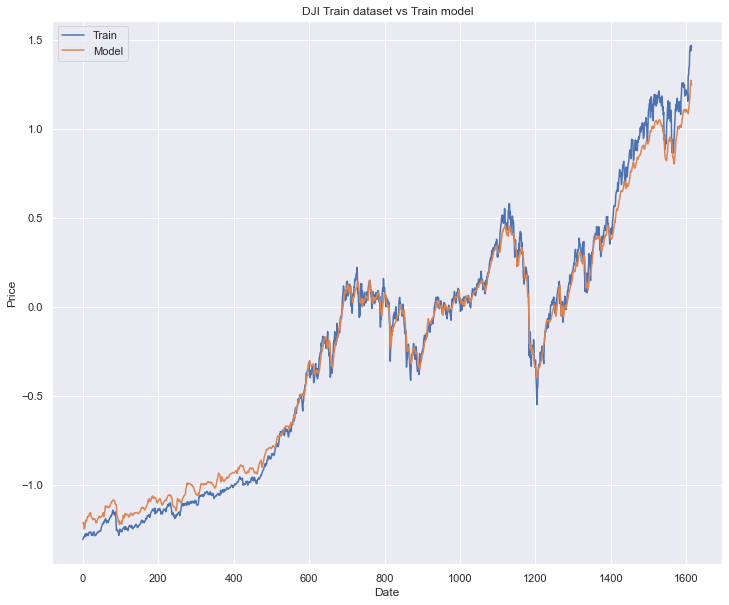

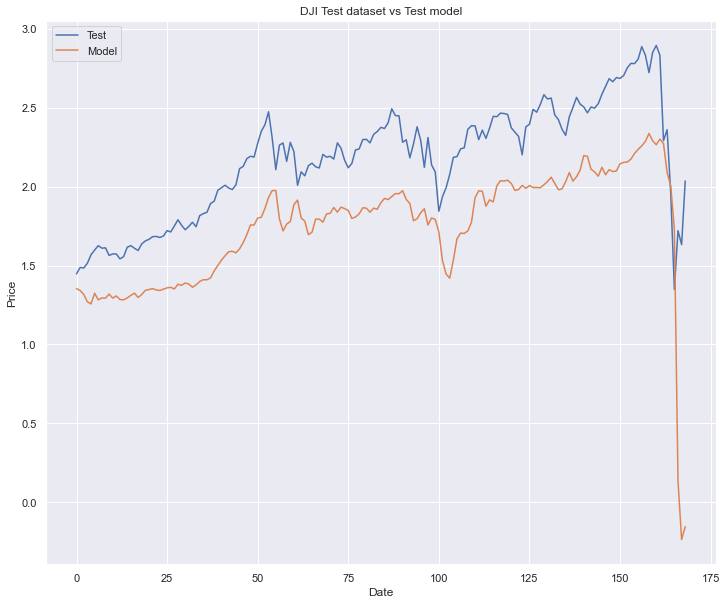

In [110]:
y_pred_train = model.predict(X_train)
y_pred_test_2 = model.predict(X_test)
model = tf.keras.models.load_model('lstm_model_correct.h5')
print(model.summary())


y_pred_test = []
# Predict each step in the test set and then train the model with the current step for the next step
for i in range(len(X_test)):
    step = model.predict(np.expand_dims(X_test[i], axis=0))
    y_pred_test.append(np.squeeze(step))
    temp_x = np.concatenate((X_train, X_test[:i]), axis=0)
    temp_y = np.concatenate((Y_train, Y_test[:i]), axis=0)
    model.fit(temp_x, temp_y, epochs=15)
    print('Data point {}:'.format(i))


a_train = r2_score(Y_train, y_pred_train)
print('Accuracy score on train set:')
print(a_train.round(3))

a_test = r2_score(Y_test, y_pred_test)
print('Accuracy score on test set:')
print(a_test.round(3))


concat_train = pd.concat([pd.DataFrame(columns=['Train'], data=Y_train[:]), pd.DataFrame(columns=['Model'], data=y_pred_train[:])], axis=1)
concat_train.plot(figsize=(12, 10))
plt.title('DJI Train dataset vs Train model')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()


concat_test = pd.concat([pd.DataFrame(columns=['Test'], data=Y_test[:]), pd.DataFrame(columns=['Model'], data=y_pred_test[:])], axis=1)
concat_test.plot(figsize=(12, 10))
plt.title('DJI Test dataset vs Test model')
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()

### Conclusion and Further Improvements <a class="anchor" id="Ending"></a>

As you can see from the training set graph, the LSTM NN makes a good job at predicting the weekly prices with an exception of the first and last values. A reason for this divergence in prices may be that the training set lacks enough values for the LSTM NN to learn how to predict in this scenarios. In the test set, the model predictions lags and has a fixed divergence from the real test set. To solve this problem, improvements will be necessary. Here are some improvements I will continue to implement in order to increase accuracy: 
- Use daily data in order to predict in smaller steps. Many information is missing when predicting friday's price with monday's data.


- Create a weighting dataset for training all prices but with higher weights for more recent prices. This could improve the accuracy by forcing the algorithm to focus on prices which are more similar to current prices.  


- Add more technical and macroeconomic variables to capture more information. 


- XGBoost to predict the gap between the real test dataset and the test model. 